In [29]:
import numpy as np
from PIL import Image
from osgeo import gdal
gdal.UseExceptions()
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from skimage.color import rgb2lab
from skimage import color, filters, exposure
import torch

In [30]:
DS_rgb= r"W:\2023_tiles\K076z\OMWRGBMRVL_K076z_01_02.jpg"
DS_grey= r"V:\project\cyclegan\tiles_1950_gray\tiles_1950_gray.1.png"
DS_big = r"W:\2023\OMWRGBMRVL_K156z.jp2"

DS_DIR = Path(r'W:\1979').glob('*.jp2')

In [31]:
ds = gdal.Open(DS_rgb)
trf= np.array(ds.GetGeoTransform())
trf.reshape(2,-1)

array([[ 1.3808100e+05,  1.5000000e-01,  0.0000000e+00],
       [ 2.2300005e+05,  0.0000000e+00, -1.5000000e-01]])

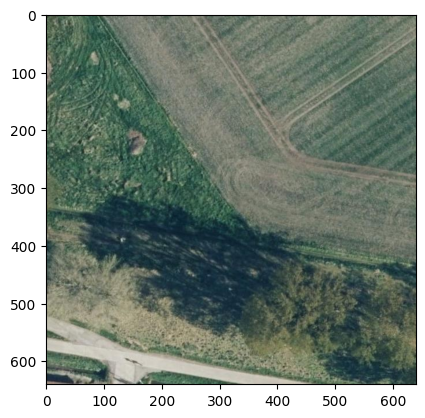

In [43]:

img = ds.ReadAsArray(xoff=0, yoff=0).transpose((1, 2, 0))
plt.imshow(exposure.rescale_intensity(img, in_range=(0, 255) ))

In [ ]:
for i in range(gdal.GetDriverCount()):
    drv = gdal.GetDriver(i)
    if drv.GetMetadataItem(gdal.DCAP_RASTER):
        print(
         f" \"{drv.GetDescription()}\" :\".{drv.GetMetadataItem(gdal.DMD_EXTENSIONS)}\" " )


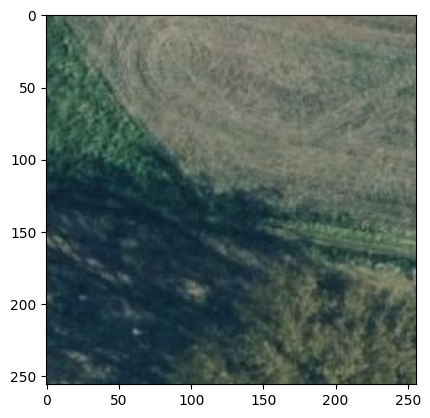

In [4]:
imsize = 256
b =ds.GetRasterBand(1)
b.ComputeRasterMinMax()

img = ds.ReadAsArray(xoff=256, yoff=256, xsize=imsize, ysize=imsize).transpose((1, 2, 0))
plt.imshow( np.pad()

(256, 306)

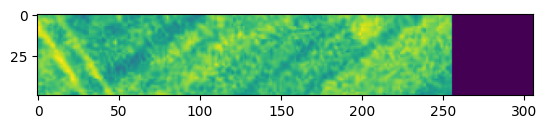

In [20]:

img = ds.ReadAsArray(xoff=256, yoff=0, xsize=imsize, ysize=imsize)
img =np.pad( img[0], ((0,0),(0,50 )) )

plt.imshow( img[:50] )
img.shape

In [40]:
aug = lambda img: exposure.adjust_gamma( 
                         gamma= np.random.uniform(low=0.5, high=2), 
                         image= filters.unsharp_mask(image=img, 
                                             radius=np.random.randint(0,15) ) 
                                    )

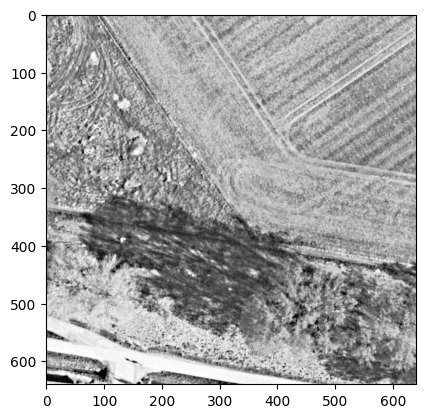

In [72]:
plt.imshow( color.rgb2lab( aug(img) )[:,:,0] , cmap='Greys_r')

In [7]:
def raster(jp2):
    ds = gdal.Open(jp2)
    xsize, ysize = (ds.RasterXSize, ds.RasterYSize)
    for xoff in range(0,xsize -255, 256):
        for yoff in range(0,ysize -255,256):
            _r = ds.ReadAsArray(xoff=xoff, yoff=yoff , xsize=256, ysize=256)
            if _r is None: break
            if np.median(_r) != 255 and np.median(_r) != 0:
                yield _r

In [22]:

ds=  gdal.Open(DS_rgb)
transformMatrix =  list(ds.GetGeoTransform())
transformMatrix

[138081.0, 0.15, 0.0, 223000.05000000002, 0.0, -0.15]

In [16]:
transformMatrix[0] = transformMatrix[0] +400
transformMatrix[3] = transformMatrix[3] +400

transformMatrix

[140081.0, 0.15, 0.0, 225000.05000000002, 0.0, -0.15]

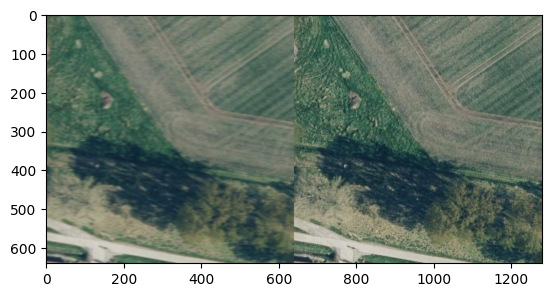

In [367]:
def aug( img):
      "some simple data augmentation on img "
      img = img +  np.random.randint(-10,10)
      return filters.gaussian(image=img, sigma=(np.random.randint(0,4) , np.random.randint(0,4)) )  

_dd=  gdal.Open(DS_rgb) 
b1= _dd.ReadAsArray().transpose((1, 2, 0))
lb = color.rgb2lab( b1 )


lb[:,:,0] = aug( lb[:,:,0] )
rbg = color.lab2rgb( lb ) 
s= np.hstack([rbg, b1/255] )

plt.imshow( s ) 

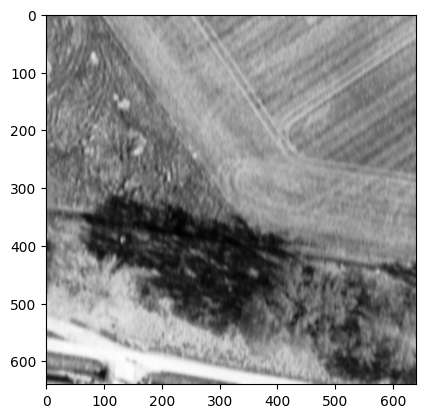

In [345]:
plt.imshow( lb[:,:,0] , cmap='Greys_r' )

In [120]:
def aug(img):
    return exposure.adjust_gamma( gamma= np.random.uniform(low=0.5, high=2), 
              image= filters.unsharp_mask(image=img, radius=np.random.randint(0,15) )  )

aug = v2.Compose([ v2.ToImage(), 
    # v2.RandomPhotometricDistort()
])

ds=  gdal.Open(DS_rgb).ReadAsArray() 
dd = aug(  ds.transpose((1, 2, 0))  )

# f, axs = plt.subplots(1, 2)
# axs[0].imshow(ds.transpose((1, 2, 0)))
# axs[1].imshow(dd)
# dd
torch.Tensor(ds).type(torch.float32)

tensor([[[ 88.,  94.,  82.,  ..., 108., 105.,  93.],
         [ 82.,  90.,  81.,  ..., 107., 109., 100.],
         [ 75.,  85.,  78.,  ..., 113., 119., 112.],
         ...,
         [155., 156., 157.,  ...,  56.,  58.,  54.],
         [149., 151., 154.,  ...,  56.,  59.,  57.],
         [150., 152., 154.,  ...,  56.,  61.,  60.]],

        [[107., 113., 101.,  ..., 123., 120., 108.],
         [101., 109., 100.,  ..., 122., 124., 115.],
         [ 94., 104.,  97.,  ..., 128., 134., 127.],
         ...,
         [138., 139., 140.,  ...,  79.,  81.,  77.],
         [132., 134., 137.,  ...,  79.,  82.,  80.],
         [131., 133., 135.,  ...,  79.,  84.,  83.]],

        [[ 85.,  91.,  79.,  ..., 104., 101.,  89.],
         [ 79.,  87.,  78.,  ..., 103., 105.,  96.],
         [ 72.,  82.,  75.,  ..., 109., 115., 108.],
         ...,
         [128., 129., 130.,  ...,  73.,  75.,  71.],
         [116., 118., 121.,  ...,  73.,  76.,  74.],
         [114., 116., 118.,  ...,  73.,  78.,  77.]]]

In [10]:
tr = v2.Compose([
            v2.RandomCrop((256, 256), pad_if_needed=True, fill=255 ),
            v2.RandomAdjustSharpness(0 , p=0.1), v2.RandomAutocontrast( p=0.1),
            v2.Resize((256, 256),  v2.InterpolationMode.BICUBIC)  #should not be nessesary, but less make sure.
        ])

In [21]:
itr = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=False)])

In [10]:
ds = gdal.Open(DS_big)
xsize, ysize = (ds.RasterXSize, ds.RasterYSize)
(xsize*ysize)/256**2

NameError: name 'DS_big' is not defined

In [14]:
f= list(raster(DS_big))

In [29]:
from model.gdal_Dataset import gdalTestDataset, gdalTrainDataset
from torch.utils.data import DataLoader

In [31]:
dl = DataLoader(gdalTestDataset(DS_big, imsize=256), batch_size=32)

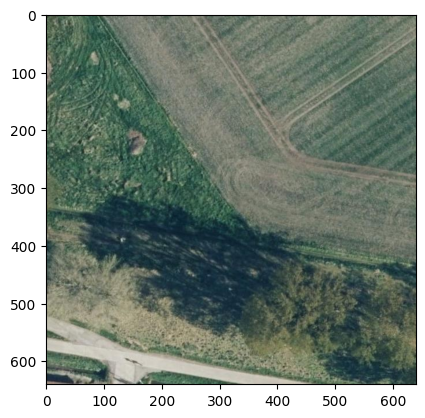

In [12]:
a = ds.ReadAsArray()
plt.imshow( a.transpose((1, 2, 0)) )

array([ 94,  90,  85, ..., 129, 118, 116], dtype=uint8)

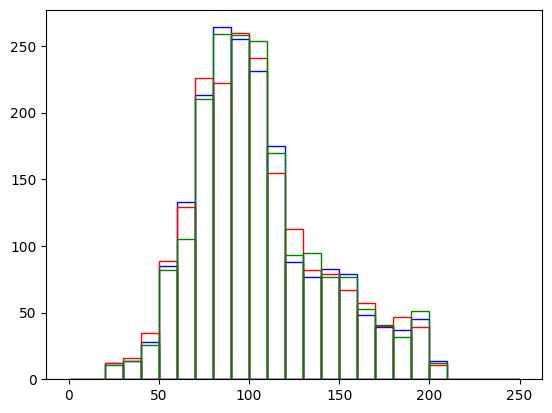

In [44]:
bins = np.arange(0,255, 10)
plt.hist(a[:,:,1].reshape(1,-1).squeeze(), bins = bins, edgecolor='b',  fill=False)
plt.hist(a[:,:,0].reshape(1,-1).squeeze(), bins = bins, edgecolor='r', fill=False)
plt.hist(a[:,:,2].reshape(1,-1).squeeze(), bins = bins, edgecolor='g',  fill=False)
plt.show()

In [28]:
aw  =Path(DS_big)
aw.parent / f"haool_{aw.name}"

WindowsPath('W:/2023/haool_OMWRGBMRVL_K156z.jp2')

In [20]:
paths = Path(r'W:\2023_tiles').glob('*/*.csv')


with open(r'W:\2023_tiles\index_wkt.csv', 'w') as out_idx:
    out_idx.write('NAME;XMIN;XMAX;YMIN;YMAX;wkt\n')
    for p in paths:
        in_csv = p.open('r', newline=None)
        for line in in_csv:
            line = line.strip()
            if len(line) > 5:
                NAME,XMIN,XMAX,YMIN,YMAX = line.split(';')
                XMIN,XMAX,YMIN,YMAX = [float(n) for n in (XMIN,XMAX,YMIN,YMAX)]
                kb = NAME.split('_')[1]
                wkt = f'"POLYGON(({XMIN} {YMIN}, {XMAX} {YMIN}, {XMAX} {YMAX}, {XMAX} {YMIN}))"'
                out_idx.write(f'{kb}/{NAME};{XMIN};{XMAX};{YMIN};{YMAX};{wkt}\n')
            else:
                continue

In [4]:
import pandas as pd

categories=  {"NONE": 0, "GREEN": 1, "AGRO": 2, "WOOD": 3,
              "WATER":4, "ROAD": 5, "BUILDING": 6, }

In [5]:
ds_ = pd.read_feather(r"W:\2023_1m_tiles\tile2023_weigths.arrow")
ds_

,fid,location,BBK_sum,BBK_median,W,geometry
0,2,2023_1m_002_313.jpg,7118.0,2.0,1,"[[[[177744. 244363.], [178256. 244363.], [1782..."
1,4,2023_1m_003_311.jpg,8193.0,2.0,1,"[[[[176720. 243851.], [177232. 243851.], [1772..."
2,5,2023_1m_003_312.jpg,18970.0,2.0,1,"[[[[177232. 243851.], [177744. 243851.], [1777..."
3,6,2023_1m_003_313.jpg,24931.0,2.0,4,"[[[[177744. 243851.], [178256. 243851.], [1782..."
4,7,2023_1m_003_314.jpg,24313.0,2.0,4,"[[[[178256. 243851.], [178768. 243851.], [1787..."
...,...,...,...,...,...,...
52607,52786,2023_1m_179_207.jpg,5375.0,2.0,1,"[[[[123472. 153739.], [123984. 153739.], [1239..."
52608,52787,2023_1m_179_241.jpg,27367.0,3.0,4,"[[[[140880. 153739.], [141392. 153739.], [1413..."
52609,52788,2023_1m_179_242.jpg,12774.0,3.0,1,"[[[[141392. 153739.], [141904. 153739.], [1419..."
52610,52790,2023_1m_180_205.jpg,3106.0,2.0,1,"[[[[122448. 153227.], [122960. 153227.], [1229..."


In [9]:
z=  [[2,2], [2,2]]
y= [[1,1], [1,0]]
x=  [[0,0], [0,0]]
np.stack([x,y,z], axis=0)


array([[[0, 0],
        [0, 0]],

       [[1, 1],
        [1, 0]],

       [[2, 2],
        [2, 2]]])

In [2]:
import cv2, glob, os
import numpy as np
imgs = glob.glob(r'W:\2023_1m_tiles\*.jpg')

c= 0
for img in imgs:
    nm, _ = os.path.splitext(img)
    wld = nm + ".wld"
    aux = nm + ".jpg.aux.xml"

    # try:
    _img = cv2.imread(img)
    if np.mean(_img) > 252 or np.mean(_img) < 3:
        os.remove(img)
        os.remove(wld)
        os.remove(aux)
        c += 1
    # except:
    #     print("ERROR", nm)
    #     continue
print(c)

34774


In [36]:
ds = ds.rename(columns={'BBK_1': 'BBK_CAT'})

In [43]:
ds.BBK_CAT.fillna(0, inplace=True)
ds.BBK_CAT = ds.BBK_CAT.astype(int)

In [49]:
ds.to_feather(r"W:\2023_tiles\2023tiles_landuse.arrow")